<a href="https://colab.research.google.com/github/YuriySamorodov/MIPT/blob/main/%D0%A1%D0%B5%D0%BC%D0%B5%D1%81%D1%82%D1%80%202/Deep%20Learning/Deep_Learning_HW2_Yuriy_Samorodov_Ensemble_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание букв английского алфавита

Этот notebook содержит решение для распознавания букв английского алфавита на искаженных и зашумленных изображениях с использованием сверточных нейронных сетей (CNN).

## Описание задачи
- **Цель**: Классифицировать 26 английских букв (A-Z) на зашумленных RGB изображениях 48x48
- **Обучающие данные**: 20,000 размеченных изображений
- **Тестовые данные**: 50,000 изображений для предсказания
- **Целевая точность**: ≥ 0.82
- **Классы**: 0=A, 1=B, ..., 25=Z

In [ ]:
%cd /kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan

/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan


In [ ]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Библиотеки для глубокого обучения
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-06-08 01:55:41.591350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749347741.765749      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749347741.816435      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
print(f"Версия TensorFlow: {tf.__version__}")
print(f"GPU доступно: {tf.config.list_physical_devices('GPU')}")

Версия TensorFlow: 2.18.0
GPU доступно: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Установка случайных сидов для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

# Настройки отображения
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



## 1. Загрузка и исследование данных

Загружаем обучающие изображения и метки, исследуем их структуру и распределение.

In [ ]:
# Загрузка обучающих данных
print("Загрузка обучающих данных...")
images = np.load('images.npy')
labels = np.load('labels.npy')

print(f"Размер массива изображений: {images.shape}")
print(f"Размер массива меток: {labels.shape}")
print(f"Тип данных изображений: {images.dtype}")
print(f"Тип данных меток: {labels.dtype}")
print(f"Диапазон значений изображений: [{images.min()}, {images.max()}]")
print(f"Уникальные метки: {np.unique(labels)}")
print(f"Количество классов: {len(np.unique(labels))}")

Загрузка обучающих данных...
Размер массива изображений: (20000, 48, 48, 3)
Размер массива меток: (20000,)
Тип данных изображений: uint8
Тип данных меток: int64
Диапазон значений изображений: [0, 255]
Уникальные метки: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Количество классов: 26


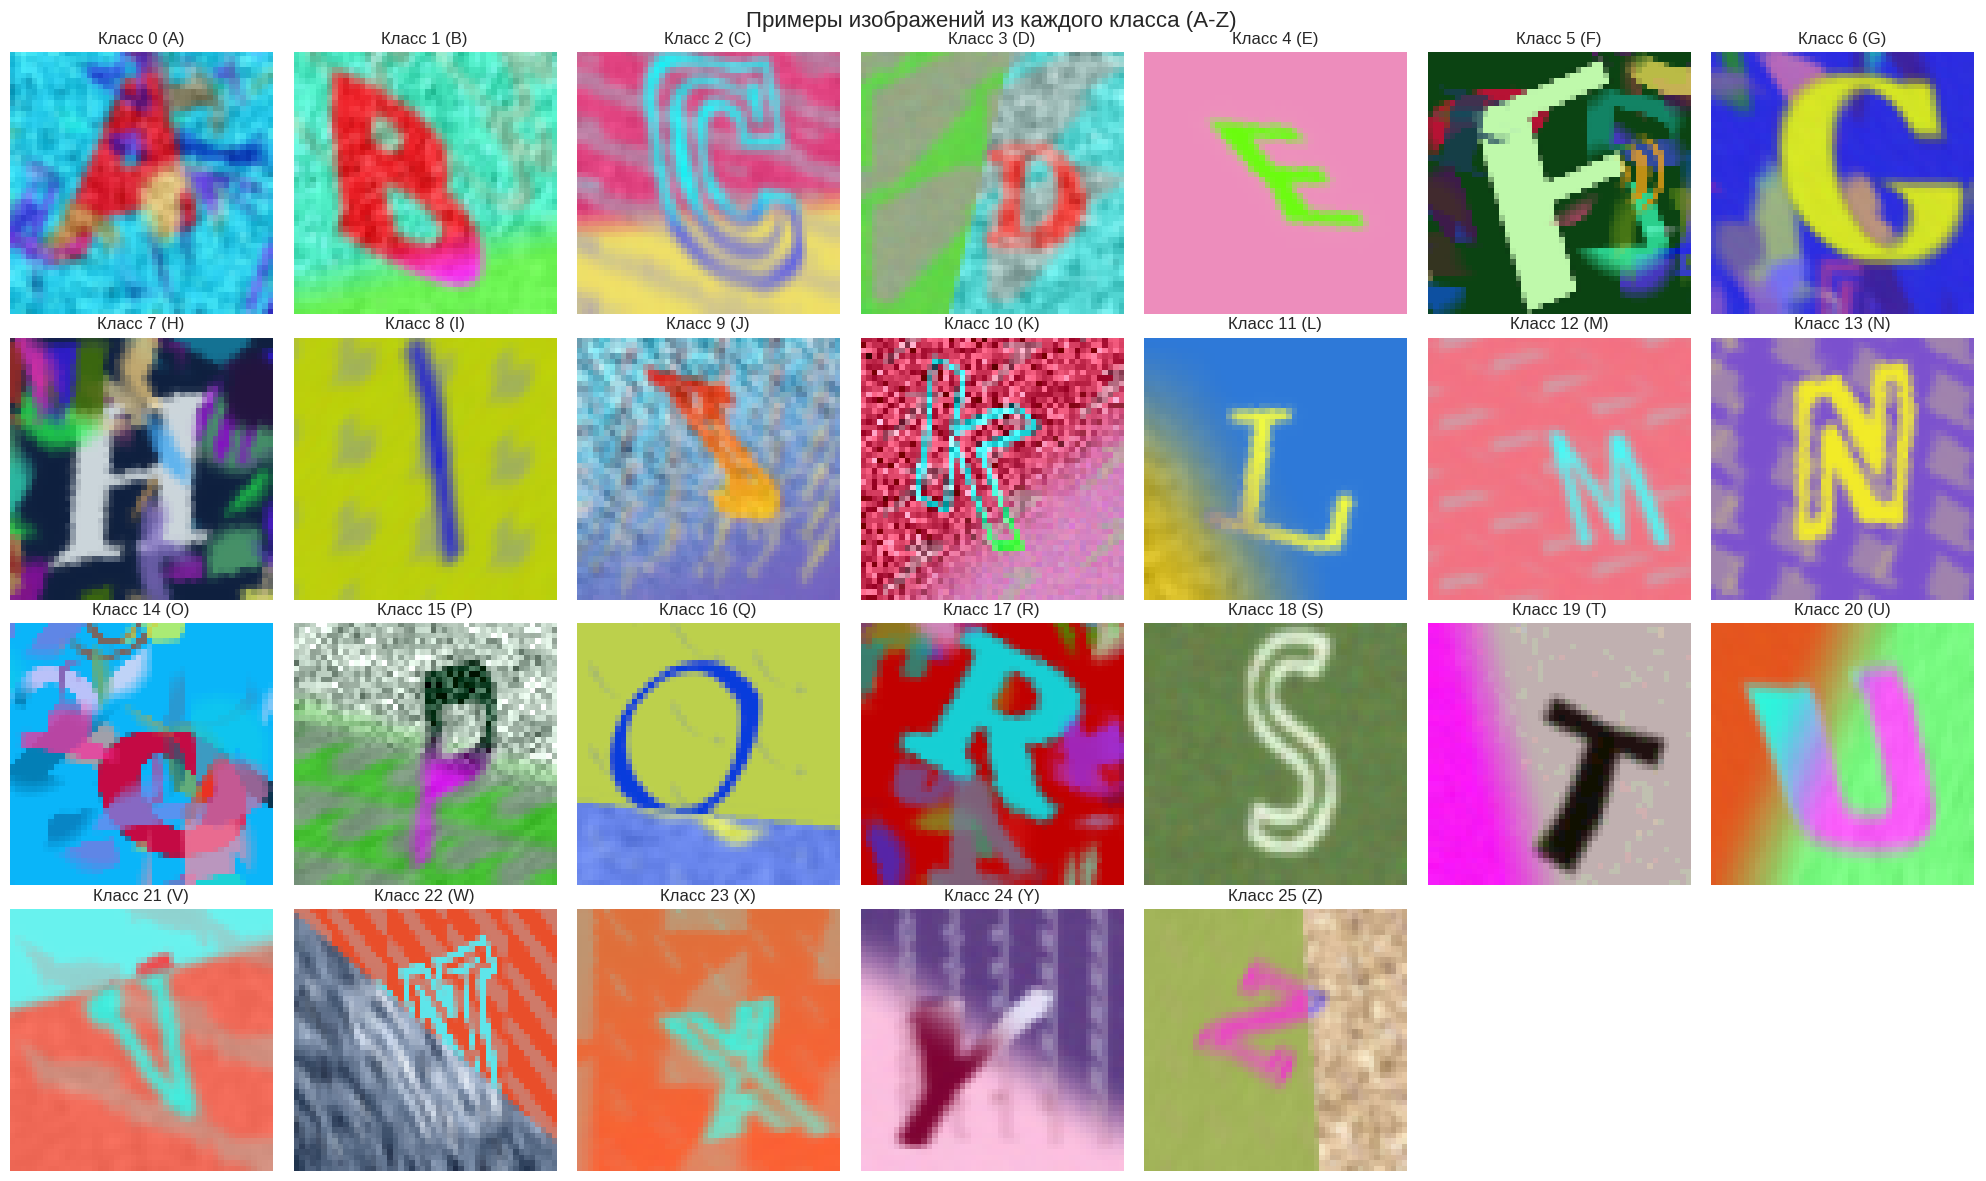

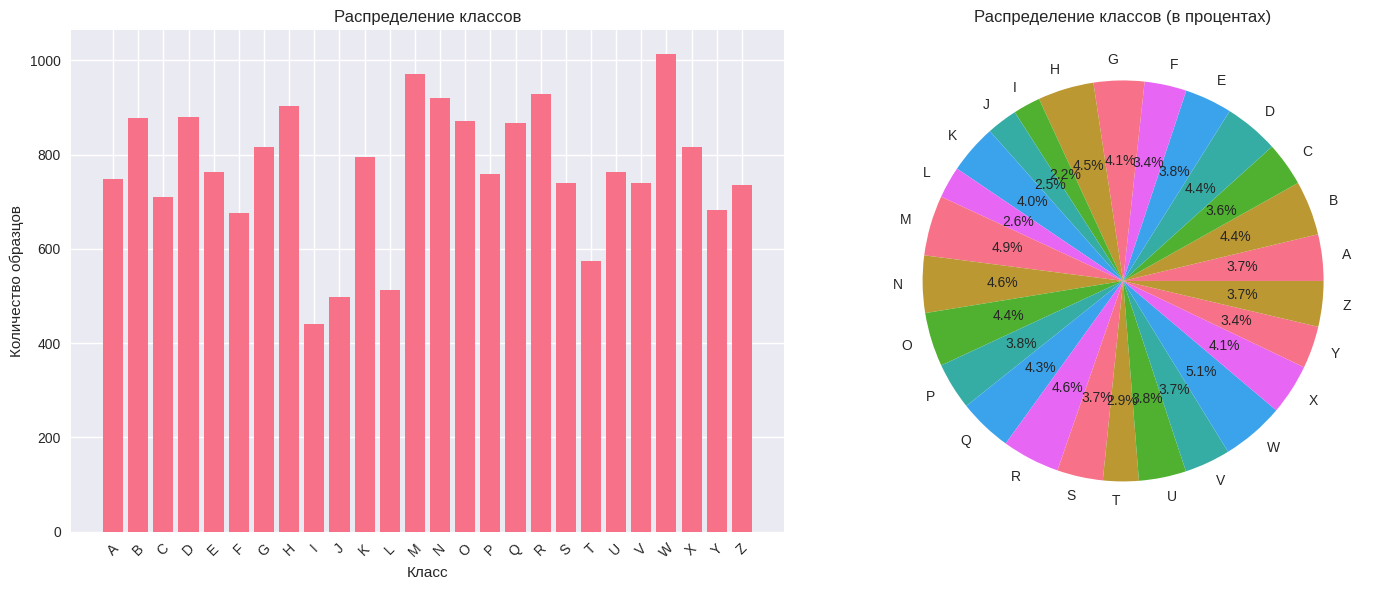


Распределение классов:
Класс A: 748 образцов (3.7%)
Класс B: 878 образцов (4.4%)
Класс C: 710 образцов (3.5%)
Класс D: 880 образцов (4.4%)
Класс E: 764 образцов (3.8%)
Класс F: 677 образцов (3.4%)
Класс G: 816 образцов (4.1%)
Класс H: 904 образцов (4.5%)
Класс I: 440 образцов (2.2%)
Класс J: 497 образцов (2.5%)
Класс K: 794 образцов (4.0%)
Класс L: 512 образцов (2.6%)
Класс M: 972 образцов (4.9%)
Класс N: 921 образцов (4.6%)
Класс O: 871 образцов (4.4%)
Класс P: 759 образцов (3.8%)
Класс Q: 866 образцов (4.3%)
Класс R: 929 образцов (4.6%)
Класс S: 739 образцов (3.7%)
Класс T: 575 образцов (2.9%)
Класс U: 763 образцов (3.8%)
Класс V: 739 образцов (3.7%)
Класс W: 1013 образцов (5.1%)
Класс X: 816 образцов (4.1%)
Класс Y: 682 образцов (3.4%)
Класс Z: 735 образцов (3.7%)


In [ ]:
# Визуализация примеров изображений из каждого класса
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
fig.suptitle('Примеры изображений из каждого класса (A-Z)', fontsize=16)

for i in range(26):
    # Найти первое изображение класса i
    class_indices = np.where(labels == i)[0]
    if len(class_indices) > 0:
        sample_image = images[class_indices[0]]
        row, col = divmod(i, 7)
        axes[row, col].imshow(sample_image)
        axes[row, col].set_title(f'Класс {i} ({chr(65+i)})', fontsize=12)
        axes[row, col].axis('off')

# Удаление лишних подграфиков
for i in range(26, 28):
    row, col = divmod(i, 7)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# График распределения классов
plt.figure(figsize=(15, 6))
label_counts = np.bincount(labels)
class_names = [chr(65+i) for i in range(26)]

plt.subplot(1, 2, 1)
plt.bar(range(26), label_counts)
plt.xlabel('Класс')
plt.ylabel('Количество образцов')
plt.title('Распределение классов')
plt.xticks(range(26), class_names)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(label_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Распределение классов (в процентах)')

plt.tight_layout()
plt.show()

print("\nРаспределение классов:")
for i in range(26):
    print(f"Класс {chr(65+i)}: {label_counts[i]} образцов ({label_counts[i]/len(labels)*100:.1f}%)")

## 2. Предобработка изображений

Нормализация данных изображений и подготовка их для обучения.

In [ ]:
# Нормализация изображений к диапазону [0, 1]
X = images.astype('float32') / 255.0
y = to_categorical(labels, num_classes=26)

print(f"Размер предобработанных изображений: {X.shape}")
print(f"Размер one-hot кодированных меток: {y.shape}")
print(f"Диапазон значений изображений после нормализации: [{X.min()}, {X.max()}]")

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nОбучающая выборка: {X_train.shape[0]} образцов")
print(f"Валидационная выборка: {X_val.shape[0]} образцов")

# Аугментация данных для обучения
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Буквы не должны отражаться по горизонтали
    fill_mode='nearest'
)

print("\nНастроена аугментация данных:")
print("- Поворот: ±15 градусов")
print("- Сдвиг по ширине/высоте: ±10%")
print("- Сдвиг: ±10%")
print("- Масштабирование: ±10%")

Размер предобработанных изображений: (20000, 48, 48, 3)
Размер one-hot кодированных меток: (20000, 26)
Диапазон значений изображений после нормализации: [0.0, 1.0]

Обучающая выборка: 16000 образцов
Валидационная выборка: 4000 образцов

Настроена аугментация данных:
- Поворот: ±15 градусов
- Сдвиг по ширине/высоте: ±10%
- Сдвиг: ±10%
- Масштабирование: ±10%


## 3. Построение нейронной сети

Определение архитектуры сверточной нейронной сети (CNN), оптимизированной для распознавания букв.

In [ ]:
def create_cnn_model(input_shape=(48, 48, 3), num_classes=26):
    """
    Создание CNN модели для распознавания алфавита
    """
    model = models.Sequential([
        # Первый сверточный блок
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Второй сверточный блок
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Третий сверточный блок
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Четвертый сверточный блок (без MaxPooling)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Dropout(0.5),

        # Сглаживание и полносвязные слои
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Создание модели
model = create_cnn_model()

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Отображение архитектуры модели
model.summary()

# Подсчет общего количества параметров
total_params = model.count_params()
print(f"\nОбщее количество параметров: {total_params:,}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749347757.491511      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,446,842 (5.52 MB)

 Trainable params: 1,444,346 (5.51 MB)

 Non-trainable params: 2,496 (9.75 KB)


Общее количество параметров: 1,446,842


## 4. Обучение модели

Обучение CNN на обучающих данных с колбэками для ранней остановки и уменьшения скорости обучения.

In [ ]:
# Определение колбэков
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Параметры обучения
BATCH_SIZE = 32
EPOCHS = 100

print(f"Параметры обучения:")
print(f"- Размер батча: {BATCH_SIZE}")
print(f"- Максимальное количество эпох: {EPOCHS}")
print(f"- Терпение ранней остановки: 10")
print(f"- Терпение уменьшения скорости обучения: 5")

# Обучение модели
print("\nНачало обучения...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nОбучение завершено!")

Параметры обучения:
- Размер батча: 32
- Максимальное количество эпох: 100
- Терпение ранней остановки: 10
- Терпение уменьшения скорости обучения: 5

Начало обучения...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749347766.435705      82 service.cc:148] XLA service 0x7bd808002160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749347766.436592      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749347767.250406      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/500 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0405 - loss: 4.7933     

I0000 00:00:1749347774.267586      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.0430 - loss: 4.1857 - val_accuracy: 0.0382 - val_loss: 3.7425 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.0443 - loss: 3.5836 - val_accuracy: 0.0413 - val_loss: 3.4367 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.0400 - loss: 3.4310 - val_accuracy: 0.0480 - val_loss: 3.2546 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0424 - loss: 3.3677 - val_accuracy: 0.0450 - val_loss: 3.2633 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0463 - loss: 3.3184 - val_accuracy: 0.0485 - val_loss: 3.2764 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.0535 - loss: 3.2786 - val_accuracy: 0.0608 - val_loss: 3.2569 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0732 - loss: 

## 5. Оценка модели

Оценка обученной модели на валидационной выборке и визуализация процесса обучения.

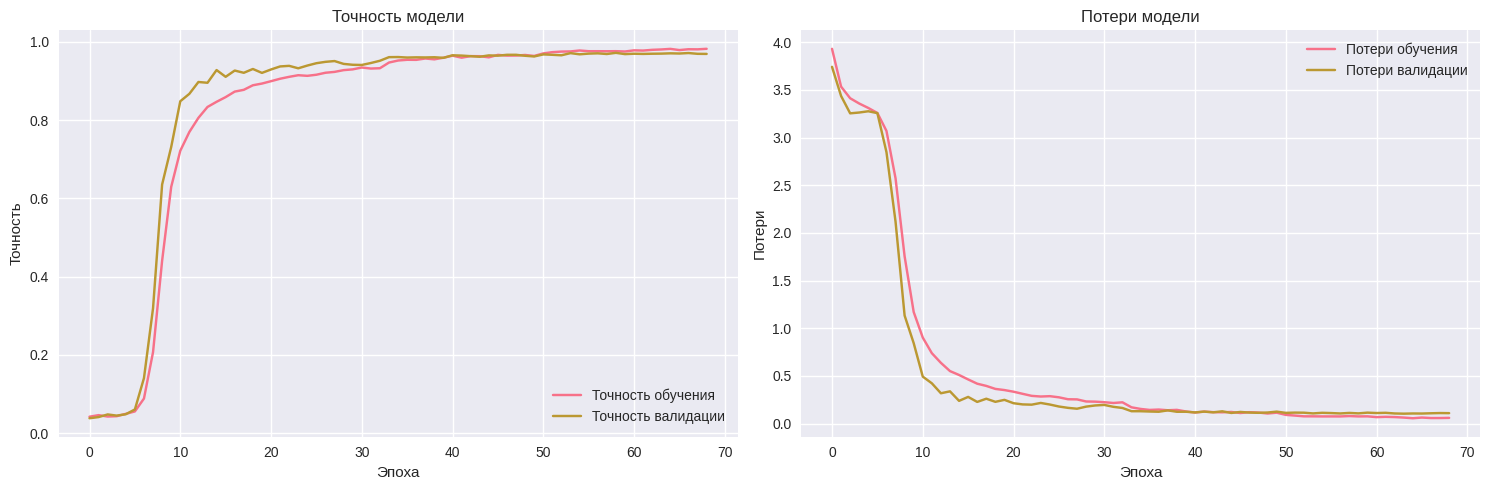


Результаты валидации:
- Потери: 0.1079
- Точность: 0.9720 (97.20%)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Отчет о классификации:
              precision    recall  f1-score   support

           A       1.00      0.98      0.99       150
           B       0.96      0.95      0.96       176
           C       0.96      0.96      0.96       142
           D       0.99      0.96      0.98       176
           E       0.95      0.94      0.94       153
           F       0.96      0.96      0.96       135
           G       0.97      0.96      0.97       163
           H       0.97      0.97      0.97       181
           I       0.94      0.90      0.92        88
           J       0.99      0.94      0.96        99
           K       0.97      0.97      0.97       159
           L       0.95      0.99      0.97       102
           M       0.98      0.98      0.98       194
           N       0.98      1.00      0.99       184
           O       0.93      0.96      0.95       174
  

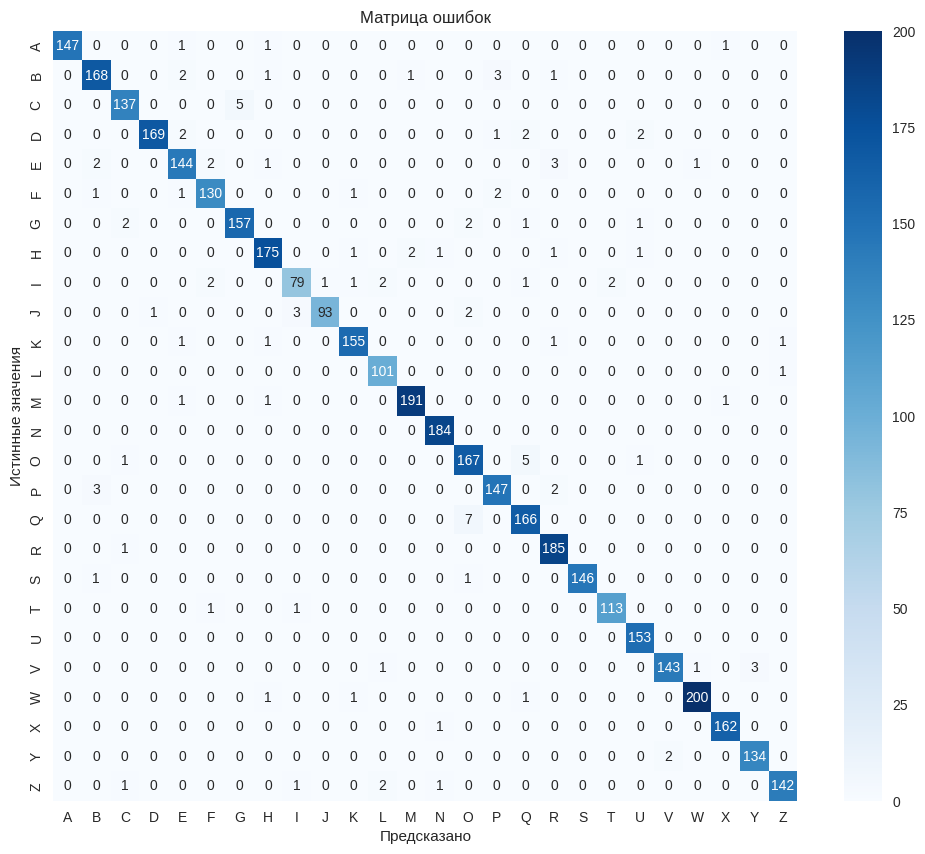

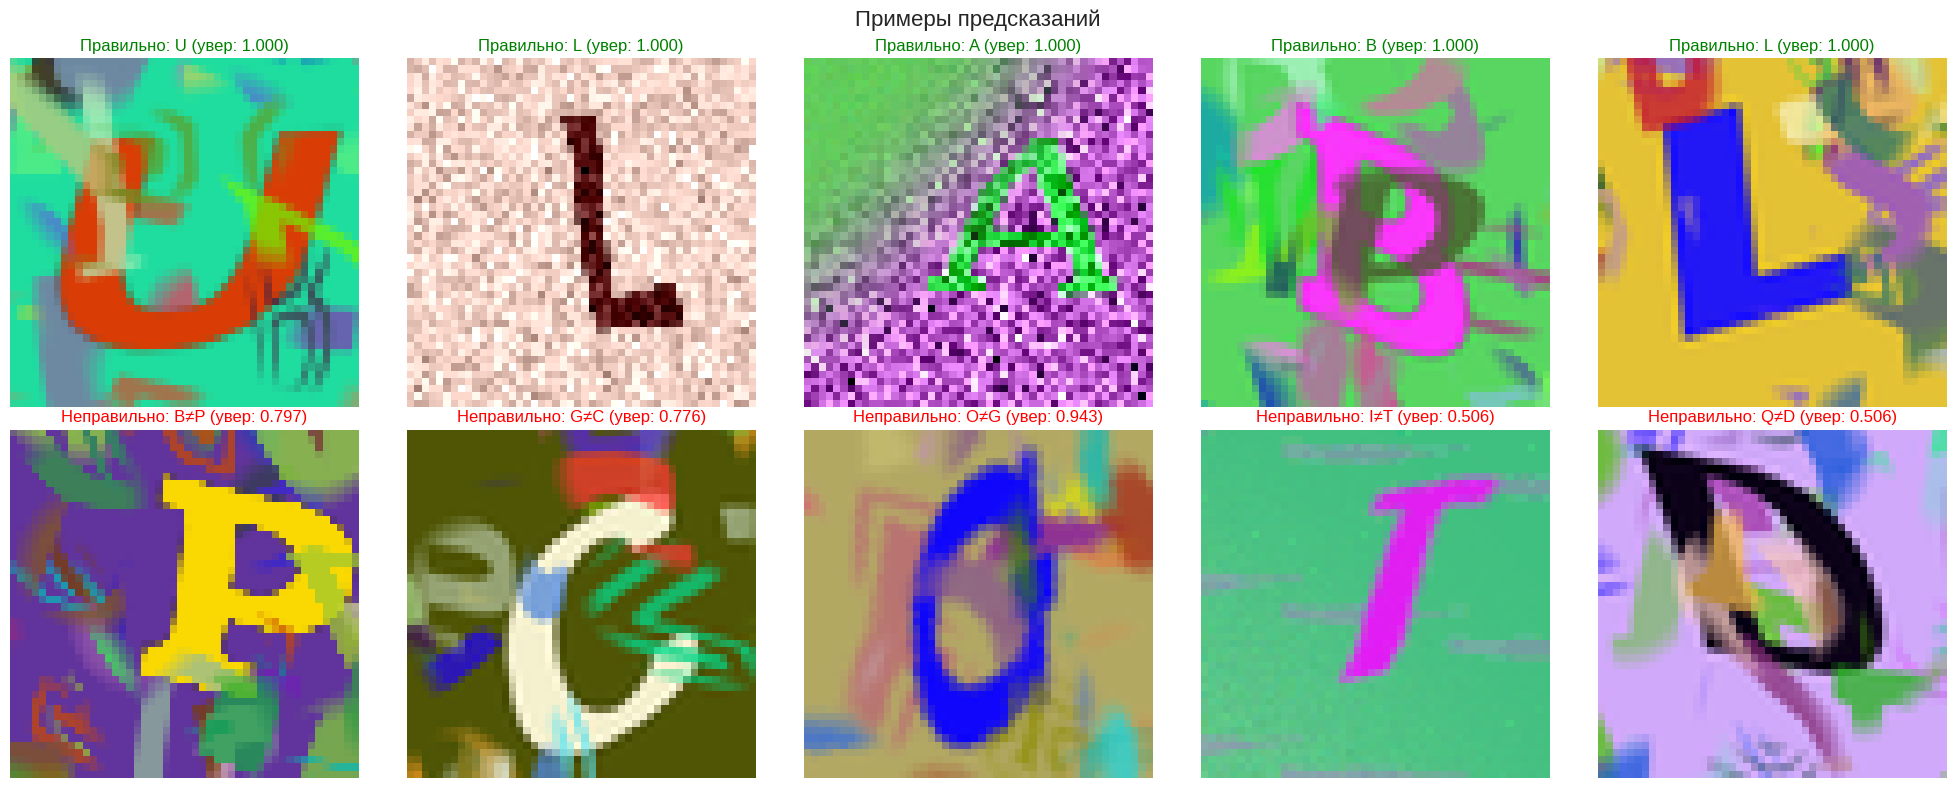

In [ ]:
# График истории обучения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График точности обучения и валидации
axes[0].plot(history.history['accuracy'], label='Точность обучения')
axes[0].plot(history.history['val_accuracy'], label='Точность валидации')
axes[0].set_title('Точность модели')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Точность')
axes[0].legend()
axes[0].grid(True)

# График потерь обучения и валидации
axes[1].plot(history.history['loss'], label='Потери обучения')
axes[1].plot(history.history['val_loss'], label='Потери валидации')
axes[1].set_title('Потери модели')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Потери')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Оценка на валидационной выборке
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nРезультаты валидации:")
print(f"- Потери: {val_loss:.4f}")
print(f"- Точность: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Предсказания на валидационной выборке
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Отчет о классификации
class_names = [chr(65+i) for i in range(26)]
print("\nОтчет о классификации:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Матрица ошибок
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок')
plt.xlabel('Предсказано')
plt.ylabel('Истинные значения')
plt.show()

# Отображение некоторых правильных и неправильных предсказаний
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Примеры предсказаний', fontsize=16)

# Правильные предсказания
correct_indices = np.where(y_pred_classes == y_true_classes)[0][:5]
for i, idx in enumerate(correct_indices):
    axes[0, i].imshow(X_val[idx])
    pred_letter = chr(65 + y_pred_classes[idx])
    true_letter = chr(65 + y_true_classes[idx])
    confidence = y_pred[idx].max()
    axes[0, i].set_title(f'Правильно: {true_letter} (увер: {confidence:.3f})', color='green')
    axes[0, i].axis('off')

# Неправильные предсказания
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0][:5]
for i, idx in enumerate(incorrect_indices):
    axes[1, i].imshow(X_val[idx])
    pred_letter = chr(65 + y_pred_classes[idx])
    true_letter = chr(65 + y_true_classes[idx])
    confidence = y_pred[idx].max()
    axes[1, i].set_title(f'Неправильно: {pred_letter}≠{true_letter} (увер: {confidence:.3f})', color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 6. Генерация предсказаний

Загрузка тестовых изображений и использование обученной модели для предсказания меток классов.

Загрузка тестовых данных...
Размер тестовых изображений: (50000, 48, 48, 3)
Тип данных тестовых изображений: uint8
Диапазон значений тестовых изображений: [0, 255]
Размер предобработанных тестовых изображений: (50000, 48, 48, 3)

Генерация предсказаний...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Размер предсказаний: (50000, 26)
Размер предсказанных классов: (50000,)
Уникальные предсказанные классы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


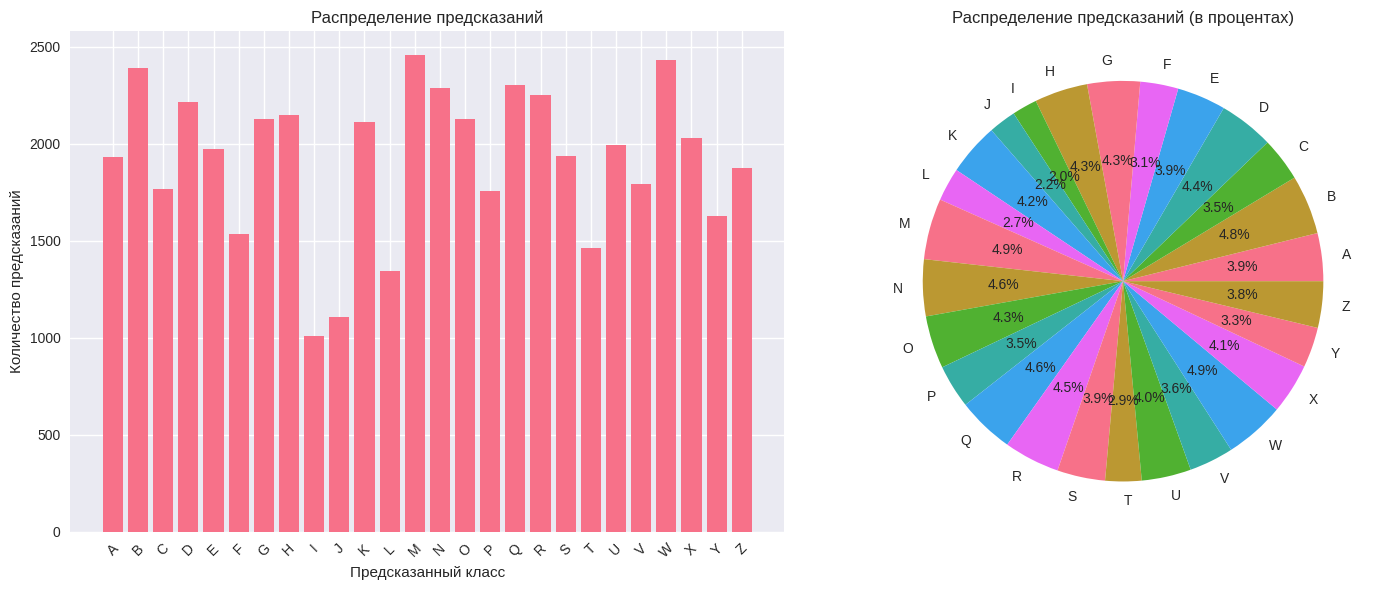


Распределение предсказаний:
Класс A: 1932 предсказаний (3.9%)
Класс B: 2392 предсказаний (4.8%)
Класс C: 1766 предсказаний (3.5%)
Класс D: 2217 предсказаний (4.4%)
Класс E: 1971 предсказаний (3.9%)
Класс F: 1536 предсказаний (3.1%)
Класс G: 2126 предсказаний (4.3%)
Класс H: 2149 предсказаний (4.3%)
Класс I: 1010 предсказаний (2.0%)
Класс J: 1107 предсказаний (2.2%)
Класс K: 2113 предсказаний (4.2%)
Класс L: 1343 предсказаний (2.7%)
Класс M: 2460 предсказаний (4.9%)
Класс N: 2287 предсказаний (4.6%)
Класс O: 2128 предсказаний (4.3%)
Класс P: 1756 предсказаний (3.5%)
Класс Q: 2301 предсказаний (4.6%)
Класс R: 2253 предсказаний (4.5%)
Класс S: 1936 предсказаний (3.9%)
Класс T: 1463 предсказаний (2.9%)
Класс U: 1996 предсказаний (4.0%)
Класс V: 1795 предсказаний (3.6%)
Класс W: 2430 предсказаний (4.9%)
Класс X: 2031 предсказаний (4.1%)
Класс Y: 1627 предсказаний (3.3%)
Класс Z: 1875 предсказаний (3.8%)


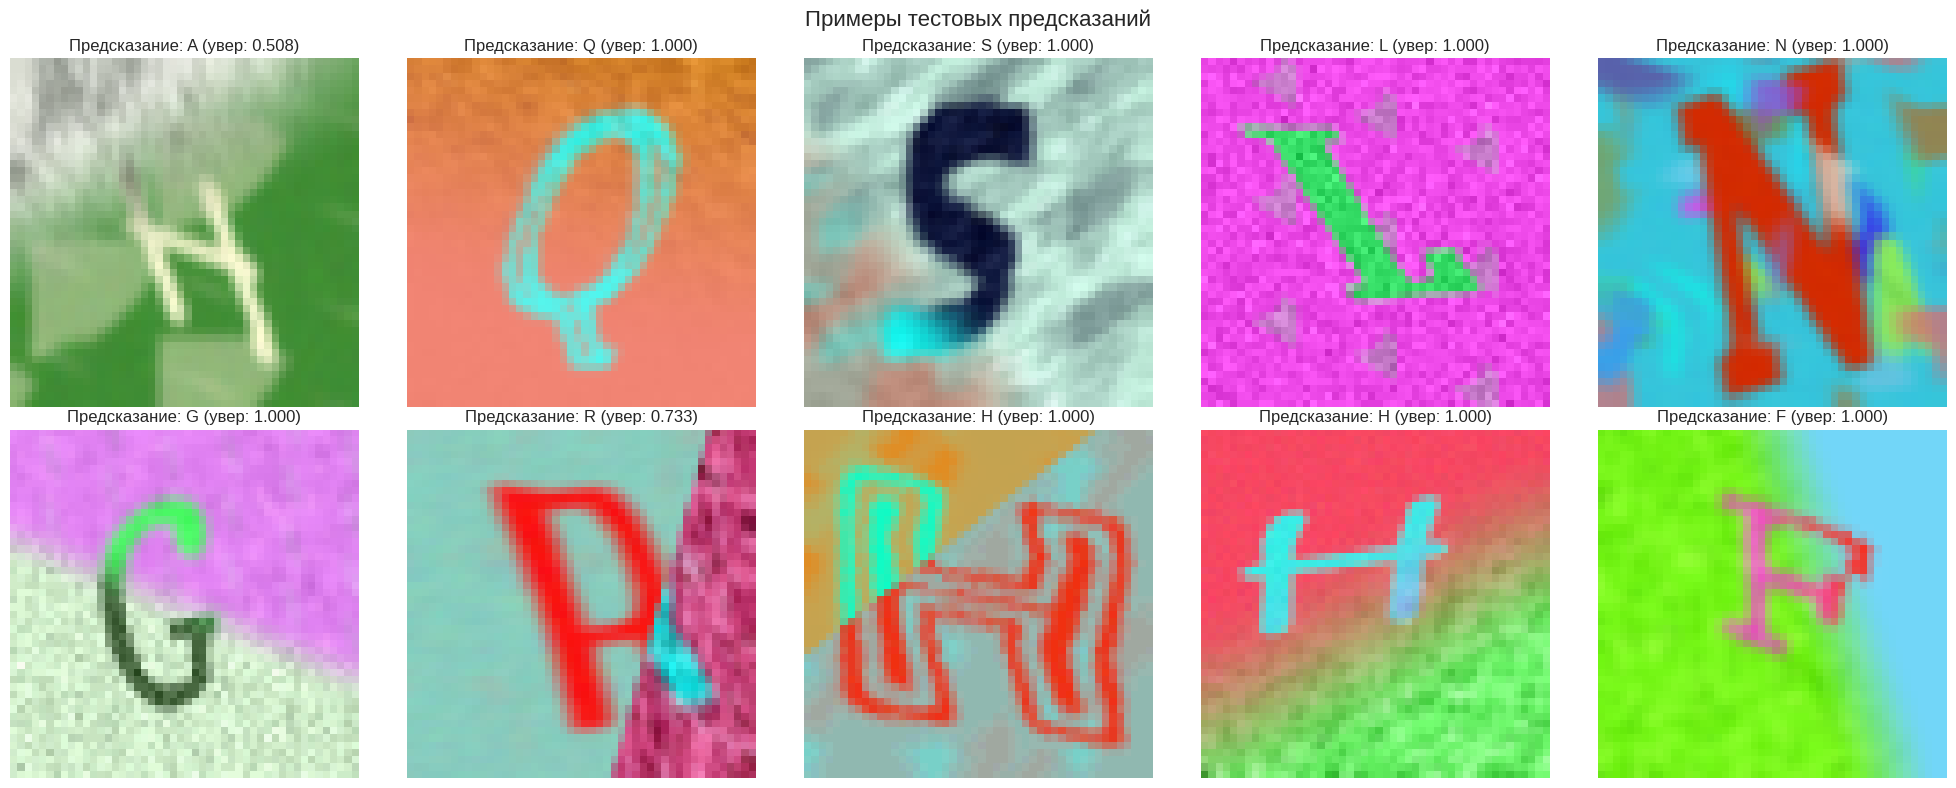

In [ ]:
# Загрузка тестовых данных
print("Загрузка тестовых данных...")
test_images = np.load('images_sub.npy')
print(f"Размер тестовых изображений: {test_images.shape}")
print(f"Тип данных тестовых изображений: {test_images.dtype}")
print(f"Диапазон значений тестовых изображений: [{test_images.min()}, {test_images.max()}]")

# Предобработка тестовых изображений (так же, как и для обучающих)
X_test = test_images.astype('float32') / 255.0
print(f"Размер предобработанных тестовых изображений: {X_test.shape}")

# Генерация предсказаний
print("\nГенерация предсказаний...")
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

print(f"Размер предсказаний: {test_predictions.shape}")
print(f"Размер предсказанных классов: {test_pred_classes.shape}")
print(f"Уникальные предсказанные классы: {np.unique(test_pred_classes)}")

# Показать распределение предсказаний
plt.figure(figsize=(15, 6))
pred_counts = np.bincount(test_pred_classes, minlength=26)
class_names = [chr(65+i) for i in range(26)]

plt.subplot(1, 2, 1)
plt.bar(range(26), pred_counts)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество предсказаний')
plt.title('Распределение предсказаний')
plt.xticks(range(26), class_names)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(pred_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Распределение предсказаний (в процентах)')

plt.tight_layout()
plt.show()

print("\nРаспределение предсказаний:")
for i in range(26):
    print(f"Класс {chr(65+i)}: {pred_counts[i]} предсказаний ({pred_counts[i]/len(test_pred_classes)*100:.1f}%)")

# Показать примеры предсказаний с уверенностью
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Примеры тестовых предсказаний', fontsize=16)

for i in range(10):
    row, col = divmod(i, 5)
    idx = np.random.randint(0, len(X_test))
    axes[row, col].imshow(X_test[idx])
    pred_letter = chr(65 + test_pred_classes[idx])
    confidence = test_predictions[idx].max()
    axes[row, col].set_title(f'Предсказание: {pred_letter} (увер: {confidence:.3f})')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 7. Подготовка файла для отправки

Форматирование предсказаний в CSV файл, соответствующий структуре sample_submission.csv.

In [ ]:
# Создание датафрейма для отправки
submission = pd.DataFrame({
    'Id': range(len(test_pred_classes)),
    'Category': test_pred_classes
})

print(f"Размер файла для отправки: {submission.shape}")
print("\nПервые 10 строк файла для отправки:")
print(submission.head(10))

print("\nПоследние 10 строк файла для отправки:")
print(submission.tail(10))

# Проверка соответствия формата образцу
sample_submission = pd.read_csv('sample_submission.csv')
print(f"\nРазмер образца файла для отправки: {sample_submission.shape}")
print(f"Размер нашего файла для отправки: {submission.shape}")
print(f"Столбцы совпадают: {list(submission.columns) == list(sample_submission.columns)}")
print(f"Диапазон Id совпадает: {submission['Id'].min()} до {submission['Id'].max()}")
print(f"Диапазон Category: {submission['Category'].min()} до {submission['Category'].max()}")

# Сохранение файла для отправки
submission_filename = '/kaggle/working/submission.csv'
submission.to_csv(submission_filename, index=False)
print(f"\nФайл для отправки сохранен как '{submission_filename}'")

# Итоговое резюме
print("\n" + "="*50)
print("РЕЗЮМЕ ОБУЧЕНИЯ")
print("="*50)
print(f"Итоговая точность валидации: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Целевая точность: 0.82 (82%)")
print(f"Цель достигнута: {'✓ ДА' if val_accuracy >= 0.82 else '✗ НЕТ'}")
print(f"Сгенерировано тестовых предсказаний: {len(test_pred_classes):,}")
print(f"Файл для отправки: {submission_filename}")
print("="*50)

if val_accuracy >= 0.82:
    print("🎉 Поздравляем! Ваша модель достигла целевой точности!")
    print("Теперь вы можете отправить файл 'submission.csv' на соревнование.")
else:
    print("⚠️  Точность модели ниже целевой. Рассмотрите:")
    print("   - Обучение на большее количество эпох")
    print("   - Корректировка архитектуры модели")
    print("   - Настройка гиперпараметров")
    print("   - Добавление большей аугментации данных")

Размер файла для отправки: (50000, 2)

Первые 10 строк файла для отправки:
   Id  Category
0   0         5
1   1         8
2   2        14
3   3        12
4   4        10
5   5         7
6   6         5
7   7        17
8   8        23
9   9        22

Последние 10 строк файла для отправки:
          Id  Category
49990  49990         7
49991  49991         7
49992  49992         1
49993  49993        11
49994  49994         2
49995  49995         4
49996  49996         0
49997  49997        14
49998  49998         3
49999  49999        25

Размер образца файла для отправки: (50000, 2)
Размер нашего файла для отправки: (50000, 2)
Столбцы совпадают: True
Диапазон Id совпадает: 0 до 49999
Диапазон Category: 0 до 25

Файл для отправки сохранен как '/kaggle/working/submission.csv'

РЕЗЮМЕ ОБУЧЕНИЯ
Итоговая точность валидации: 0.9720 (97.20%)
Целевая точность: 0.82 (82%)
Цель достигнута: ✓ ДА
Сгенерировано тестовых предсказаний: 50,000
Файл для отправки: /kaggle/working/submission.csv
🎉 Поздр

## 8. Ансамблевая модель

Для улучшения точности создадим ансамбль из нескольких CNN моделей с разными архитектурами. Ансамбль объединяет предсказания множественных моделей для получения более стабильных и точных результатов.

In [ ]:
# Функции для создания различных архитектур CNN

def create_cnn_model_v2(input_shape=(48, 48, 3), num_classes=26):
    """
    Вторая версия CNN модели с другой архитектурой
    """
    model = models.Sequential([
        # Первый блок - больше фильтров
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Второй блок
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Третий блок
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Четвертый блок
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Классификатор
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_cnn_model_v3(input_shape=(48, 48, 3), num_classes=26):
    """
    Третья версия CNN модели с использованием разных размеров фильтров
    """
    inputs = layers.Input(shape=input_shape)

    # Первый блок
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Второй блок
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Третий блок
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Четвертый блок
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Классификатор
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

def create_cnn_model_v4(input_shape=(48, 48, 3), num_classes=26):
    """
    Четвертая версия CNN модели с остаточными связями
    """
    inputs = layers.Input(shape=input_shape)

    # Первый блок
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    residual = x

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Остаточная связь
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Второй блок с остаточной связью
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    residual = x

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Третий блок
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Классификатор
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

print("Архитектуры ансамблевых моделей определены!")

Архитектуры ансамблевых моделей определены!


In [ ]:
# Создание и компиляция ансамблевых моделей
print("Создание ансамблевых моделей...")

# Список для хранения моделей
ensemble_models = []
model_names = ['CNN_v1_Original', 'CNN_v2_Deep', 'CNN_v3_MultiKernel', 'CNN_v4_Residual']

# Добавляем уже обученную модель в ансамбль
ensemble_models.append(model)
print(f"Модель 1 ({model_names[0]}): уже обучена")

# Создаем и компилируем остальные модели
model_v2 = create_cnn_model_v2()
model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
ensemble_models.append(model_v2)
print(f"Модель 2 ({model_names[1]}): создана и скомпилирована")

model_v3 = create_cnn_model_v3()
model_v3.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
ensemble_models.append(model_v3)
print(f"Модель 3 ({model_names[2]}): создана и скомпилирована")

model_v4 = create_cnn_model_v4()
model_v4.compile(
    optimizer=Adam(learning_rate=0.0012),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
ensemble_models.append(model_v4)
print(f"Модель 4 ({model_names[3]}): создана и скомпилирована")

print(f"\nВсего моделей в ансамбле: {len(ensemble_models)}")

# Показываем краткую информацию о каждой модели
for i, (model_instance, name) in enumerate(zip(ensemble_models, model_names)):
    total_params = model_instance.count_params()
    print(f"{name}: {total_params:,} параметров")

Создание ансамблевых моделей...
Модель 1 (CNN_v1_Original): уже обучена
Модель 2 (CNN_v2_Deep): создана и скомпилирована
Модель 3 (CNN_v3_MultiKernel): создана и скомпилирована
Модель 4 (CNN_v4_Residual): создана и скомпилирована

Всего моделей в ансамбле: 4
CNN_v1_Original: 1,446,842 параметров
CNN_v2_Deep: 2,885,466 параметров
CNN_v3_MultiKernel: 891,066 параметров
CNN_v4_Residual: 329,018 параметров


In [ ]:
# Обучение новых моделей ансамбля
ENSEMBLE_EPOCHS = 80  # Меньше эпох для ансамбля для ускорения
ENSEMBLE_BATCH_SIZE = 32

# Определение колбэков для ансамбля
ensemble_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

# Обучение моделей 2, 3, 4 (модель 1 уже обучена)
ensemble_histories = [history]  # История первой модели

for i in range(1, len(ensemble_models)):
    print(f"\n{'='*60}")
    print(f"ОБУЧЕНИЕ МОДЕЛИ {i+1}: {model_names[i]}")
    print(f"{'='*60}")

    current_model = ensemble_models[i]

    # Обучение текущей модели
    ensemble_history = current_model.fit(
        datagen.flow(X_train, y_train, batch_size=ENSEMBLE_BATCH_SIZE),
        steps_per_epoch=len(X_train) // ENSEMBLE_BATCH_SIZE,
        epochs=ENSEMBLE_EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=ensemble_callbacks,
        verbose=1
    )

    ensemble_histories.append(ensemble_history)

    # Оценка модели
    val_loss, val_accuracy = current_model.evaluate(X_val, y_val, verbose=0)
    print(f"\nРезультаты модели {model_names[i]}:")
    print(f"- Потери валидации: {val_loss:.4f}")
    print(f"- Точность валидации: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

print("\n🎉 Обучение всех моделей ансамбля завершено!")


ОБУЧЕНИЕ МОДЕЛИ 2: CNN_v2_Deep
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.0385 - loss: 4.2871 - val_accuracy: 0.0455 - val_loss: 3.3962 - learning_rate: 0.0010
Epoch 2/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.0432 - loss: 3.8166 - val_accuracy: 0.0512 - val_loss: 3.2967 - learning_rate: 0.0010
Epoch 3/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.0512 - loss: 3.6375 - val_accuracy: 0.0477 - val_loss: 4.8309 - learning_rate: 0.0010
Epoch 4/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.0633 - loss: 3.5035 - val_accuracy: 0.0945 - val_loss: 3.1834 - learning_rate: 0.0010
Epoch 5/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.1040 - loss: 3.2891 - val_accuracy: 0.1528 - val_loss: 2.8970 - learning_rate: 0.0010
Epoch 6/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.1713 - loss: 2.8530 - val_accuracy: 0.3663 - val_loss: 2.1387 - learning_rate: 0.0010
Epoch 7/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.3808 - loss: 2.0559

In [ ]:
# Оценка каждой модели ансамбля
print("\n" + "="*70)
print("ОЦЕНКА ОТДЕЛЬНЫХ МОДЕЛЕЙ АНСАМБЛЯ")
print("="*70)

individual_accuracies = []

for i, (model_instance, name) in enumerate(zip(ensemble_models, model_names)):
    val_loss, val_accuracy = model_instance.evaluate(X_val, y_val, verbose=0)
    individual_accuracies.append(val_accuracy)
    print(f"{name:20s}: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

print(f"\nСредняя точность отдельных моделей: {np.mean(individual_accuracies):.4f}")
print(f"Лучшая отдельная модель: {model_names[np.argmax(individual_accuracies)]} - {max(individual_accuracies):.4f}")


ОЦЕНКА ОТДЕЛЬНЫХ МОДЕЛЕЙ АНСАМБЛЯ
CNN_v1_Original     : 0.9720 (97.20%)
CNN_v2_Deep         : 0.9755 (97.55%)
CNN_v3_MultiKernel  : 0.9665 (96.65%)
CNN_v4_Residual     : 0.9643 (96.43%)

Средняя точность отдельных моделей: 0.9696
Лучшая отдельная модель: CNN_v2_Deep - 0.9755


In [ ]:
# Функция для усреднения предсказаний ансамбля
def ensemble_predict(models, X, batch_size=32):
    """
    Получение усредненных предсказаний от ансамбля моделей
    """
    predictions = []

    for i, model_instance in enumerate(models):
        print(f"Получение предсказаний от модели {i+1}/{len(models)}...")
        pred = model_instance.predict(X, batch_size=batch_size, verbose=0)
        predictions.append(pred)

    # Усреднение предсказаний
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred, predictions

# Получение предсказаний ансамбля на валидационной выборке
print("Получение предсказаний ансамбля на валидационной выборке...")
ensemble_val_pred, individual_val_preds = ensemble_predict(ensemble_models, X_val)
ensemble_val_classes = np.argmax(ensemble_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Вычисление точности ансамбля
ensemble_accuracy = accuracy_score(y_val_true_classes, ensemble_val_classes)

print(f"\n{'='*70}")
print("РЕЗУЛЬТАТЫ АНСАМБЛЯ")
print(f"{'='*70}")
print(f"Точность ансамбля: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print(f"Улучшение по сравнению с лучшей отдельной моделью: {ensemble_accuracy - max(individual_accuracies):.4f}")
print(f"Цель (≥0.82) достигнута: {'✓ ДА' if ensemble_accuracy >= 0.82 else '✗ НЕТ'}")

Получение предсказаний ансамбля на валидационной выборке...
Получение предсказаний от модели 1/4...
Получение предсказаний от модели 2/4...
Получение предсказаний от модели 3/4...
Получение предсказаний от модели 4/4...

РЕЗУЛЬТАТЫ АНСАМБЛЯ
Точность ансамбля: 0.9778 (97.78%)
Улучшение по сравнению с лучшей отдельной моделью: 0.0023
Цель (≥0.82) достигнута: ✓ ДА



Детальный отчет о классификации ансамбля:
              precision    recall  f1-score   support

           A       1.00      0.99      0.99       150
           B       0.95      0.96      0.96       176
           C       0.97      0.98      0.98       142
           D       0.99      0.98      0.98       176
           E       0.95      0.95      0.95       153
           F       0.96      0.96      0.96       135
           G       0.98      0.98      0.98       163
           H       0.99      0.97      0.98       181
           I       0.93      0.93      0.93        88
           J       0.97      0.97      0.97        99
           K       0.99      0.99      0.99       159
           L       0.96      0.98      0.97       102
           M       0.96      0.98      0.97       194
           N       0.99      0.99      0.99       184
           O       0.96      0.97      0.97       174
           P       0.97      0.97      0.97       152
           Q       0.98      0.97     

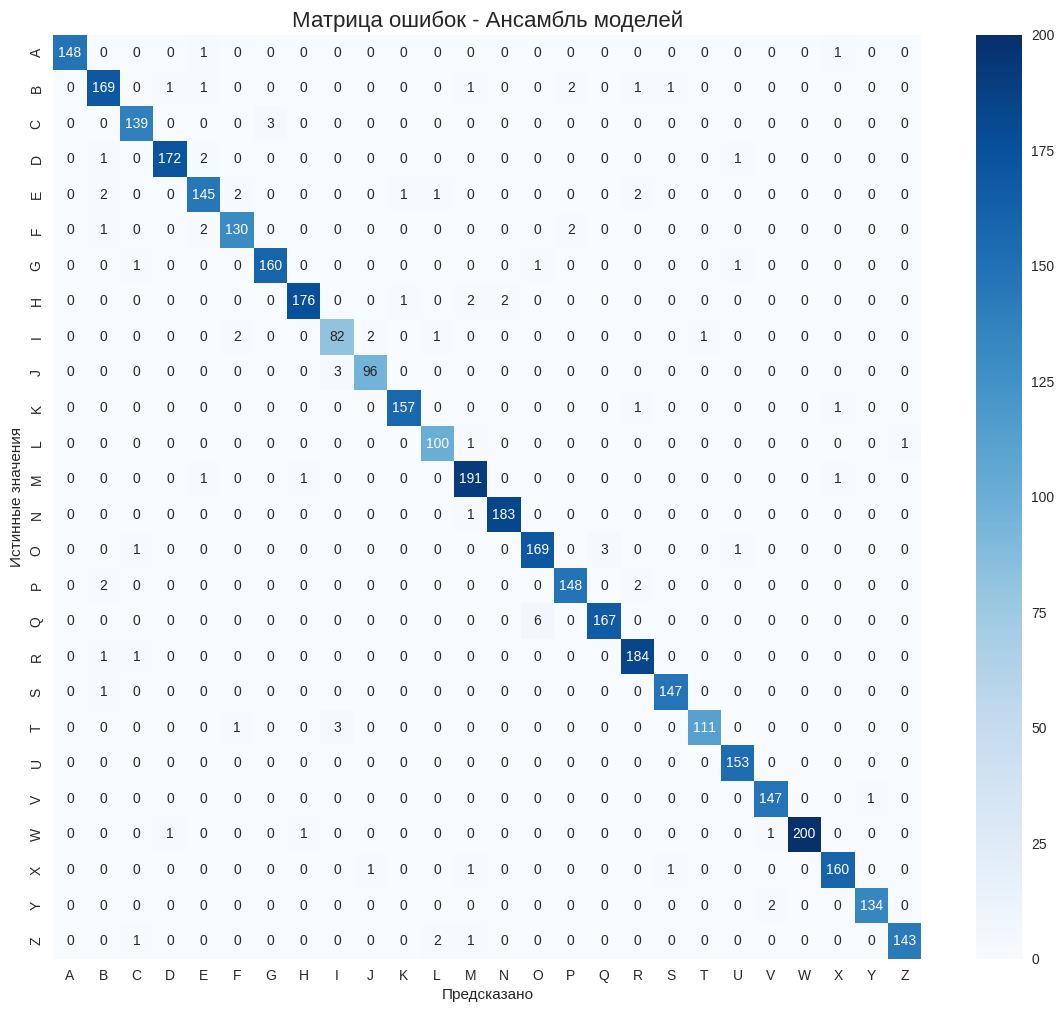

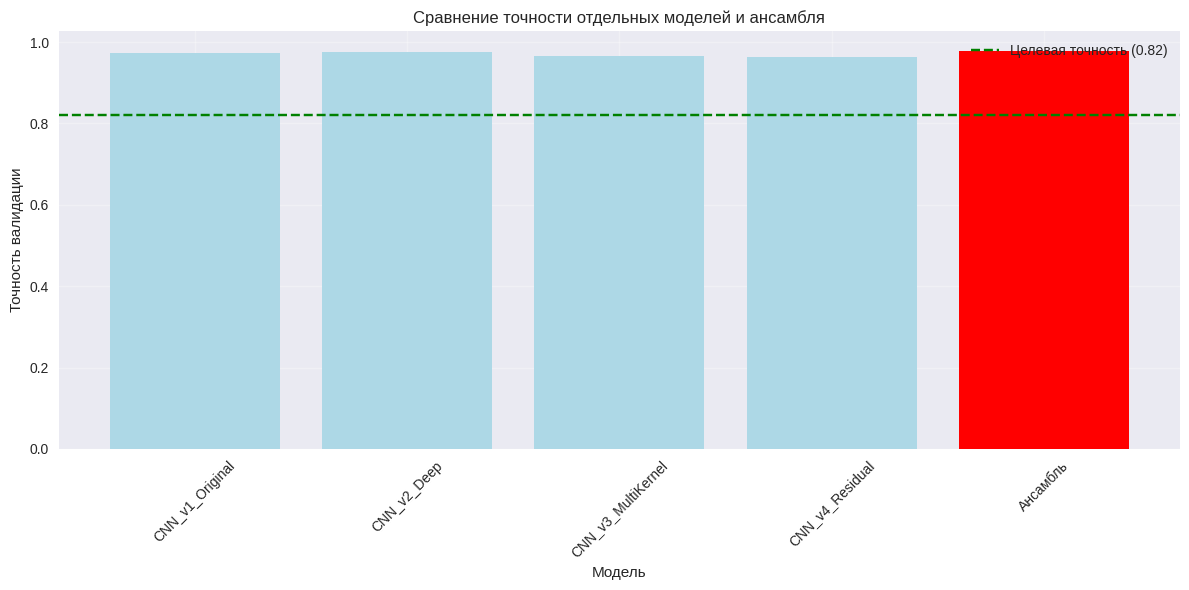

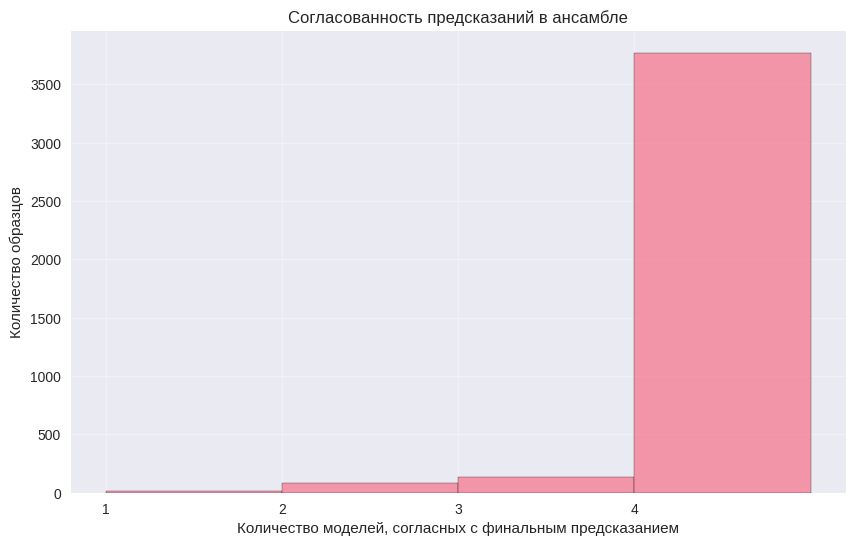


Статистика согласованности:
Среднее количество согласных моделей: 3.92
Полное согласие всех 4 моделей: 3770 образцов (94.2%)


In [ ]:
# Детальный анализ ансамбля
print("\nДетальный отчет о классификации ансамбля:")
class_names = [chr(65+i) for i in range(26)]
print(classification_report(y_val_true_classes, ensemble_val_classes, target_names=class_names))

# Матрица ошибок для ансамбля
plt.figure(figsize=(14, 12))
cm_ensemble = confusion_matrix(y_val_true_classes, ensemble_val_classes)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок - Ансамбль моделей', fontsize=16)
plt.xlabel('Предсказано')
plt.ylabel('Истинные значения')
plt.show()

# Сравнение точности отдельных моделей и ансамбля
plt.figure(figsize=(12, 6))
model_scores = individual_accuracies + [ensemble_accuracy]
model_labels = model_names + ['Ансамбль']
colors = ['lightblue'] * len(model_names) + ['red']

plt.bar(model_labels, model_scores, color=colors)
plt.xlabel('Модель')
plt.ylabel('Точность валидации')
plt.title('Сравнение точности отдельных моделей и ансамбля')
plt.xticks(rotation=45)
plt.axhline(y=0.82, color='green', linestyle='--', label='Целевая точность (0.82)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ согласованности предсказаний ансамбля
agreement_scores = []
for i in range(len(X_val)):
    individual_preds = [np.argmax(pred[i]) for pred in individual_val_preds]
    # Считаем, сколько моделей согласны с финальным предсказанием
    final_pred = ensemble_val_classes[i]
    agreement = sum(1 for pred in individual_preds if pred == final_pred)
    agreement_scores.append(agreement)

plt.figure(figsize=(10, 6))
plt.hist(agreement_scores, bins=range(1, len(ensemble_models)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Количество моделей, согласных с финальным предсказанием')
plt.ylabel('Количество образцов')
plt.title('Согласованность предсказаний в ансамбле')
plt.xticks(range(1, len(ensemble_models)+1))
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nСтатистика согласованности:")
print(f"Среднее количество согласных моделей: {np.mean(agreement_scores):.2f}")
print(f"Полное согласие всех {len(ensemble_models)} моделей: {sum(1 for score in agreement_scores if score == len(ensemble_models))} образцов ({sum(1 for score in agreement_scores if score == len(ensemble_models))/len(agreement_scores)*100:.1f}%)")


ГЕНЕРАЦИЯ ФИНАЛЬНЫХ ПРЕДСКАЗАНИЙ АНСАМБЛЯ
Получение предсказаний ансамбля на тестовых данных...
Получение предсказаний от модели 1/4...
Получение предсказаний от модели 2/4...
Получение предсказаний от модели 3/4...
Получение предсказаний от модели 4/4...
Размер предсказаний ансамбля: (50000, 26)
Размер предсказанных классов: (50000,)
Уникальные предсказанные классы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

Статистика уверенности ансамбля:
Средняя уверенность: 0.9696
Минимальная уверенность: 0.1682
Максимальная уверенность: 1.0000
Предсказания с уверенностью > 0.9: 45650 (91.3%)


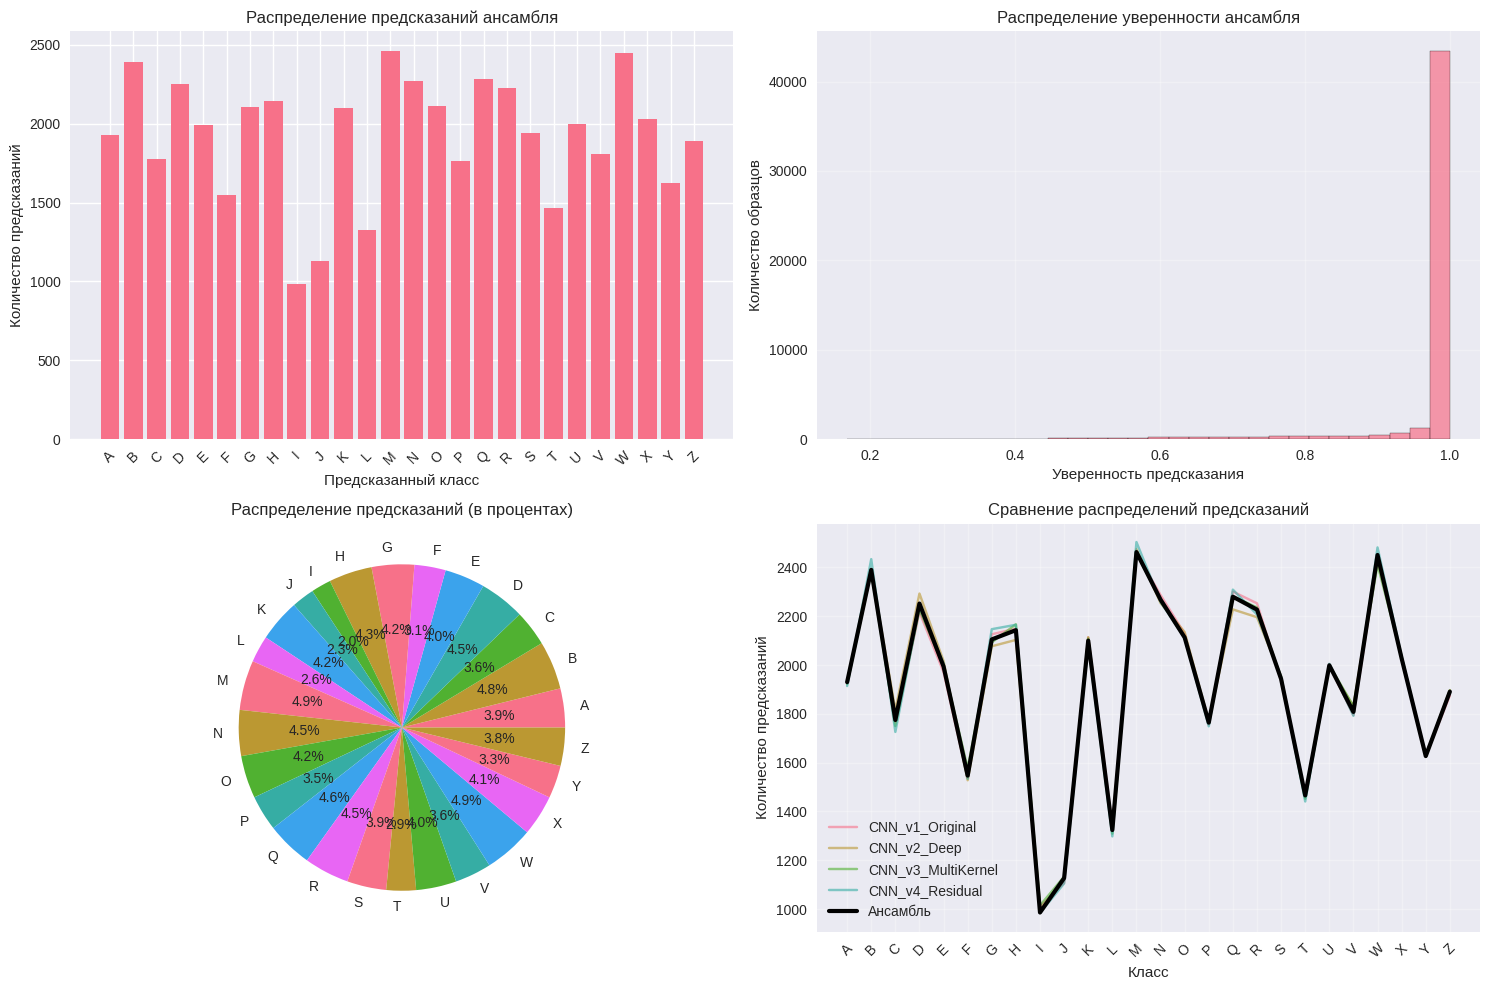


Распределение предсказаний ансамбля:
Класс A: 1930 предсказаний (3.9%)
Класс B: 2390 предсказаний (4.8%)
Класс C: 1775 предсказаний (3.5%)
Класс D: 2252 предсказаний (4.5%)
Класс E: 1994 предсказаний (4.0%)
Класс F: 1547 предсказаний (3.1%)
Класс G: 2105 предсказаний (4.2%)
Класс H: 2143 предсказаний (4.3%)
Класс I: 986 предсказаний (2.0%)
Класс J: 1127 предсказаний (2.3%)
Класс K: 2100 предсказаний (4.2%)
Класс L: 1324 предсказаний (2.6%)
Класс M: 2463 предсказаний (4.9%)
Класс N: 2268 предсказаний (4.5%)
Класс O: 2113 предсказаний (4.2%)
Класс P: 1764 предсказаний (3.5%)
Класс Q: 2280 предсказаний (4.6%)
Класс R: 2227 предсказаний (4.5%)
Класс S: 1943 предсказаний (3.9%)
Класс T: 1466 предсказаний (2.9%)
Класс U: 1999 предсказаний (4.0%)
Класс V: 1808 предсказаний (3.6%)
Класс W: 2451 предсказаний (4.9%)
Класс X: 2027 предсказаний (4.1%)
Класс Y: 1627 предсказаний (3.3%)
Класс Z: 1891 предсказаний (3.8%)


In [ ]:
# Генерация финальных предсказаний ансамбля на тестовых данных
print("\n" + "="*70)
print("ГЕНЕРАЦИЯ ФИНАЛЬНЫХ ПРЕДСКАЗАНИЙ АНСАМБЛЯ")
print("="*70)

# Получение предсказаний ансамбля на тестовых данных
print("Получение предсказаний ансамбля на тестовых данных...")
ensemble_test_pred, individual_test_preds = ensemble_predict(ensemble_models, X_test)
ensemble_test_classes = np.argmax(ensemble_test_pred, axis=1)

print(f"Размер предсказаний ансамбля: {ensemble_test_pred.shape}")
print(f"Размер предсказанных классов: {ensemble_test_classes.shape}")
print(f"Уникальные предсказанные классы: {np.unique(ensemble_test_classes)}")

# Анализ уверенности предсказаний ансамбля
ensemble_confidence = np.max(ensemble_test_pred, axis=1)
print(f"\nСтатистика уверенности ансамбля:")
print(f"Средняя уверенность: {np.mean(ensemble_confidence):.4f}")
print(f"Минимальная уверенность: {np.min(ensemble_confidence):.4f}")
print(f"Максимальная уверенность: {np.max(ensemble_confidence):.4f}")
print(f"Предсказания с уверенностью > 0.9: {sum(1 for conf in ensemble_confidence if conf > 0.9)} ({sum(1 for conf in ensemble_confidence if conf > 0.9)/len(ensemble_confidence)*100:.1f}%)")

# Распределение предсказаний ансамбля
ensemble_pred_counts = np.bincount(ensemble_test_classes, minlength=26)

plt.figure(figsize=(15, 10))

# График распределения предсказаний
plt.subplot(2, 2, 1)
plt.bar(range(26), ensemble_pred_counts)
plt.xlabel('Предсказанный класс')
plt.ylabel('Количество предсказаний')
plt.title('Распределение предсказаний ансамбля')
plt.xticks(range(26), class_names)
plt.xticks(rotation=45)

# Гистограмма уверенности
plt.subplot(2, 2, 2)
plt.hist(ensemble_confidence, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Уверенность предсказания')
plt.ylabel('Количество образцов')
plt.title('Распределение уверенности ансамбля')
plt.grid(True, alpha=0.3)

# Круговая диаграмма предсказаний
plt.subplot(2, 2, 3)
plt.pie(ensemble_pred_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Распределение предсказаний (в процентах)')

# Сравнение с отдельными моделями
plt.subplot(2, 2, 4)
for i, pred in enumerate(individual_test_preds):
    individual_classes = np.argmax(pred, axis=1)
    individual_counts = np.bincount(individual_classes, minlength=26)
    plt.plot(range(26), individual_counts, alpha=0.6, label=f'{model_names[i]}')

plt.plot(range(26), ensemble_pred_counts, 'k-', linewidth=3, label='Ансамбль')
plt.xlabel('Класс')
plt.ylabel('Количество предсказаний')
plt.title('Сравнение распределений предсказаний')
plt.legend()
plt.xticks(range(26), class_names)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nРаспределение предсказаний ансамбля:")
for i in range(26):
    print(f"Класс {chr(65+i)}: {ensemble_pred_counts[i]} предсказаний ({ensemble_pred_counts[i]/len(ensemble_test_classes)*100:.1f}%)")

In [ ]:
# Создание финального файла для отправки с ансамблем
ensemble_submission = pd.DataFrame({
    'Id': range(len(ensemble_test_classes)),
    'Category': ensemble_test_classes
})


# Сохранение файла для отправки
ensemble_submission_filename = '/kaggle/working/ensemble_submission.csv'
ensemble_submission.to_csv(ensemble_submission_filename, index=False)
